In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function


import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
from scipy.signal import argrelmin, argrelmax

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras

Using TensorFlow backend.


In [3]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager
from matplotlib.font_manager import FontProperties

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

fontP = FontProperties()
fontP.set_size(10)

In [4]:
# Check Versions
print(tf.__version__)  #1.15.0
print(keras.__version__)  #2.2.4

1.15.0
2.2.4


# Alternative DCTR fitting algorithm for $\alpha_s$ (Multiplicity Only)

This notebook trains a DCTR Reweightor paramterized by $\alpha_s$ only on multiplicity, and then performs the alternative fitting algorithm on an unknown dataset. 

## Load and Process data

In [5]:
# Path to downloaded data from Zenodo
data_dir = '/data0/users/aandreassen/zenodo/'

In [6]:
dataset = np.load(data_dir + '1D_alphaS_train.npz')

In [7]:
X = dataset['X']
Y = dataset['Y']

In [8]:
Y = to_categorical(Y, num_classes=2)

In [9]:
X_mult = []
# Zipping data points with no particle with parameters

index = 0
for jet in X:
    pTs = jet[:,0]
    alphaS = jet[0][4]
    multiplicity = np.sum(pTs!=0)
    X_mult.append([multiplicity, alphaS])

In [10]:
X_mult = np.array(X_mult)

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X_mult, Y, test_size=0.2)

## Training a DCTR Model
First, we need to train a DCTR model to provide us with a reweighting function to be used during fitting.
This is taken directly from the first Gaussian Notebook.

### Build Model

In [12]:
inputs = Input((2,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr_model = Model(inputs = inputs, outputs = outputs)
dctr_model.compile(loss='categorical_crossentropy', optimizer='Adam')

### Train DCTR model

In [13]:
earlystopping = EarlyStopping(patience = 10,
                              restore_best_weights=True)
dctr_model.fit(X_train, Y_train, 
               epochs=200, batch_size = 10000, 
               validation_data = (X_val, Y_val), 
               verbose = 0, 
               callbacks = [earlystopping])
print("Trained DCTR Model")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Trained DCTR Model


# Alternative Fit

### Setup the dataset


In [14]:
default_dataset = np.load(data_dir + 'test1D_default.npz')
unknown_dataset = np.load(data_dir + 'test1D_alphaS.npz')

In [15]:
X_0 = default_dataset['multiplicity']
X_1 = unknown_dataset['multiplicity']

labels0 = np.zeros(len(X_0))
labels1 = np.ones(len(X_1))

xvals = np.concatenate([X_0,X_1])
yvals = np.concatenate([labels0,labels1])

X_train, X_test, y_train, y_test = train_test_split(xvals, yvals, test_size=0.5)
X_train_theta, y_train_theta = shuffle(xvals, yvals)

### Defining reweighting functions

$w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

In [16]:
# from NN (DCTR)
def reweight(events, param):
    #creating tensor with same length as inputs, with theta_prime in every entry
    concat_input_and_params = K.ones(shape=events.shape) * param
    #combining and reshaping into correct format:
    model_inputs = K.concatenate((events, concat_input_and_params), axis=-1)

    f = dctr_model(model_inputs)
    weights = (f[:, 1]) / (f[:, 0])
    weights = K.expand_dims(weights, axis=1)
    return weights

## Fitting Model: Scan

We'll start by showing that for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$.

### Creating Model

In [17]:
myinputs = Input(shape=(1,), dtype = tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)
          
model = Model(inputs=myinputs, outputs=predictions)
model.summary()

batch_size = 1000
earlystopping = EarlyStopping(patience=10, restore_best_weights=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


In [18]:
def my_loss_wrapper(inputs,
                      val=0.,
                      loss='categorical_crossentropy',
                      batch_size=1000):
    x  = inputs
    x = K.gather(x, np.arange(batch_size))
    
    theta_prime = val

    weights = reweight(x, theta_prime)
    
    def my_loss(y_true, y_pred):
        if loss == 'MSE':
            # Mean Squared Loss
            t_loss = y_true * (y_true - y_pred)**2 + weights * (
                1. - y_true) * (y_true - y_pred)**2
        elif loss == 'categorical_crossentropy':
            # Categorical Cross-Entropy Loss

            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -((y_true) * K.log(y_pred) + weights *
                       (1 - y_true) * K.log(1 - y_pred))
        else:
            raise ValueError(
                "loss must be set to 'MSE' or 'categorical_crossentropy'")
        
        return K.mean(t_loss)
    
    return my_loss

### Training Model

In [19]:
thetas = np.linspace(0.10, 0.18, 33)
vlvals = []
lvals = []

for theta in thetas:
    print("Testing theta = ", theta)
    model.compile(optimizer='adam',
                  loss=my_loss_wrapper(myinputs,
                                         theta,
                                         batch_size=batch_size),
                  metrics=['accuracy'])

    history = model.fit(np.array(X_train),
                        y_train,
                        epochs=1000,
                        batch_size=batch_size,
                        validation_data=(np.array(X_test), y_test),
                        verbose=0,
                       callbacks= [earlystopping])
    
    min_lval = history.history['loss'][np.argmin(history.history['val_loss'])]
    min_vlval = np.min(history.history['val_loss'])

    lvals += [min_lval]
    vlvals += [min_vlval]
    
    print("loss: ", min_lval)
    print("val_loss: ", min_vlval)
    print("\n")
    print
    pass
print(lvals)

Testing theta =  0.1
loss:  0.6431417263878716
val_loss:  0.6430970122416814


Testing theta =  0.10250000000000001
loss:  0.6462749914328257
val_loss:  0.6464563108152813


Testing theta =  0.10500000000000001
loss:  0.649151529735989
val_loss:  0.6493619665834639


Testing theta =  0.1075
loss:  0.6519605375660791
val_loss:  0.6521370386415057


Testing theta =  0.11
loss:  0.6548755997419358
val_loss:  0.6550524616903729


Testing theta =  0.1125
loss:  0.6574764055013657
val_loss:  0.6576612424850464


Testing theta =  0.115
loss:  0.6599708298179838
val_loss:  0.6601804488897324


Testing theta =  0.11750000000000001
loss:  0.6626928268538581
val_loss:  0.662925150261985


Testing theta =  0.12
loss:  0.6656283987230724
val_loss:  0.6658125898573134


Testing theta =  0.1225
loss:  0.6685409823391173
val_loss:  0.6687207839886348


Testing theta =  0.125
loss:  0.6716494996680153
val_loss:  0.6718312011824714


Testing theta =  0.1275
loss:  0.6746676896015803
val_loss:  0.6747853

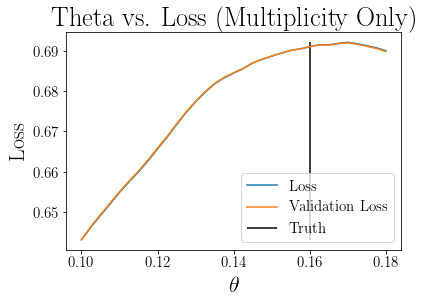

In [20]:
plt.title("Theta vs. Loss (Multiplicity Only)")
plt.plot(thetas, lvals, label='Loss')
plt.plot(thetas, vlvals, label='Validation Loss')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(0.16,
           ymin=np.min(lvals+vlvals),
           ymax=np.max(lvals+vlvals),
           label='Truth')
plt.legend()
# plt.savefig("alphaS_Fit_MultiplicitityOnly-Theta-vs-Loss.png")
plt.show()

Now, let's do the $\theta$ and $g$ optimization together with a minimax setup.

## Fitting Model: Gradient Fit

### Creating Model

In [21]:
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(
    "Theta fit = ", model_fit.layers[-1].get_weights()[-1]))

theta_fit_init = 0.12
fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(
    on_epoch_end=lambda batch, logs: fit_vals.append(model_fit.layers[-1].
                                                     get_weights()[0]))

callbacks = [print_weights, append_fit_value]

earlystopping = EarlyStopping(patience=10, restore_best_weights=True)

In [22]:
myinputs_fit = Input(shape=(1,))
x_fit = Dense(128, activation='relu')(myinputs_fit)
x2_fit = Dense(128, activation='relu')(x_fit)
predictions_fit = Dense(1, activation='sigmoid')(x2_fit)
identity = Lambda(lambda x: x + 0)(predictions_fit)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers)-1].add_weight(name="thetaX",shape=list(),initializer = keras.initializers.Constant(value = theta_fit_init),trainable=True)
model_fit.summary()

batch_size_g = 1000
batch_size_theta = len(X_train_theta)
iterations = 50

# optimizer will be refined as fit progresses for better precision
lr_initial = 5e-2
optimizer = keras.optimizers.Adam(lr=lr_initial)
index_refine = np.array([0])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 1         
Total params: 16,898
Trainable params: 16,898
Non-trainable params: 0
_________________________________________________________________


In [23]:
def my_loss_wrapper_fit(
        inputs,
        mysign=1,  # -1 for training theta, +1 for training g
        loss='categorical_crossentropy',
        batch_size=1000):
    
    x  = inputs
    x = K.gather(x, np.arange(batch_size))

    # Getting theta_prime:
    if mysign == 1:
        #  when not training theta, fetch as np array
        theta_prime = model_fit.layers[-1].get_weights()
    else:
        # when training theta, fetch as tf.Variable
        theta_prime = model_fit.trainable_weights[-1]
        
    weights = reweight(x, theta_prime)
    
    def my_loss(y_true, y_pred):
        if loss == 'MSE':
            # Mean Squared Loss
            t_loss = mysign * (y_true * (y_true - y_pred)**2 + weights *
                               (1. - y_true) * (y_true - y_pred)**2)
        elif loss == 'categorical_crossentropy':
            # Categorical Cross-Entropy Loss

            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -mysign * ((y_true) * K.log(y_pred) + weights *
                                (1 - y_true) * K.log(1 - y_pred))
        else:
            raise ValueError(
                "loss must be set to 'MSE' or 'categorical_crossentropy'")

        return K.mean(t_loss)

    return my_loss

### Training Model

In [24]:
for iteration in range(iterations):
    print("Iteration: ", iteration + 1)

    X_train, X_test, y_train, y_test = train_test_split(xvals,
                                                        yvals,
                                                        test_size=0.5)
    X_train_theta, y_train_theta = shuffle(xvals, yvals)

    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = True
        pass

    model_fit.layers[-1].trainable = False
    #     model.summary()

    # regular optimizer and batch size
    model_fit.compile(optimizer='Adam',
                      loss=my_loss_wrapper_fit(myinputs_fit,
                                               1,
                                               batch_size=batch_size_g),
                      metrics=['accuracy'])

    print("Training g")
    model_fit.fit(np.array(X_train),
                  y_train,
                  epochs=100,
                  batch_size=batch_size_g,
                  validation_data=(np.array(X_test), y_test),
                  verbose=0,
                  callbacks=[earlystopping])

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = False
        pass

    model_fit.layers[-1].trainable = True
    model_fit.compile(optimizer=optimizer,
                      loss=my_loss_wrapper_fit(myinputs_fit,
                                               -1,
                                               batch_size=batch_size_theta),
                      metrics=['accuracy'])
#     model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train_theta),
                  y_train_theta,
                  epochs=1,
                  batch_size=batch_size_theta,
                  verbose=0,
                  callbacks=callbacks)
    
    print("\n")

    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10

    fit_vals_recent = np.array(fit_vals)[(index_refine[-1]):]

    # Get RECENT relative extrema, if it alternates --> oscillatory behavior

    extrema = np.concatenate(
        (argrelmin(fit_vals_recent)[0], argrelmax(fit_vals_recent)[0]))
    extrema = extrema[extrema >= iteration - index_refine[-1] - 20]

    if (len(extrema) >= 6):  # If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print('==============================\n' +
              '====Refining Learning Rate====\n' +
              '==============================\n')
        optimizer.lr = optimizer.lr / 10.

        mean_fit = np.array([
            np.mean(fit_vals_recent[len(fit_vals_recent) -
                                    4:len(fit_vals_recent)])
        ])

        model_fit.layers[-1].set_weights(mean_fit)
    pass

Iteration:  1
Training g
Training theta
Theta fit =  0.16999985


Iteration:  2
Training g
Training theta
Theta fit =  0.207205


Iteration:  3
Training g
Training theta
Theta fit =  0.17814873


Iteration:  4
Training g
Training theta
Theta fit =  0.14909297


Iteration:  5
Training g
Training theta
Theta fit =  0.17636698


Iteration:  6
Training g
Training theta
Theta fit =  0.15026145


Iteration:  7
Training g
Training theta
Theta fit =  0.17558005


Iteration:  8
Training g
Training theta
Theta fit =  0.1507927


Iteration:  9
Training g
Training theta
Theta fit =  0.17523012


====Refining Learning Rate====

Iteration:  10
Training g
Training theta
Theta fit =  0.16054441


Iteration:  11
Training g
Training theta
Theta fit =  0.16295505


Iteration:  12
Training g
Training theta
Theta fit =  0.1605489


Iteration:  13
Training g
Training theta
Theta fit =  0.16295882


Iteration:  14
Training g
Training theta
Theta fit =  0.16054128


Iteration:  15
Training g
Training theta
Th

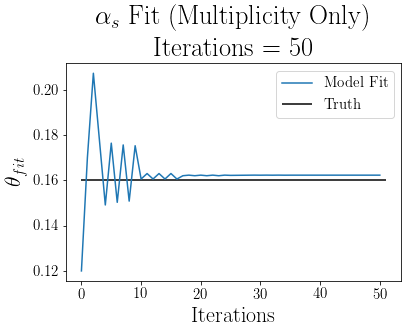

In [25]:
plt.title(r'$\alpha_s$ Fit (Multiplicity Only)'+'\nIterations = {}'.format(iterations))
plt.plot(fit_vals, label='Model Fit')
plt.hlines(0.16, 0, len(fit_vals), label='Truth')
plt.xlabel("Iterations")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
# plt.savefig(
#     "$/alpha_s$ Fit (Multiplicity Only)\nIterations = {:.0f}.png"
#     .format(iterations))
plt.show()

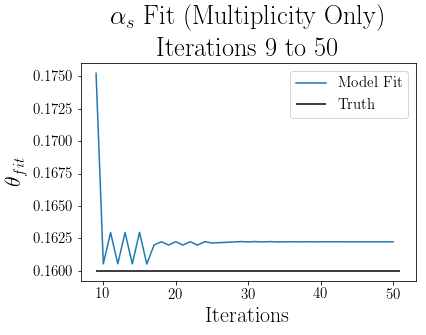

In [26]:
# Zoom into later iterations (finer fit)
fit_vals = np.array(fit_vals)
plt.title(r'$\alpha_s$ Fit (Multiplicity Only)'+'\nIterations {} to {}'.format(index_refine[1], iterations))
plt.plot(np.arange(index_refine[1], len(fit_vals)),
         fit_vals[index_refine[1]:],
         label='Model Fit')
plt.hlines(0.16, index_refine[1], len(fit_vals), label='Truth')
plt.xlabel("Iterations")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
# plt.savefig(
#     "$/alpha_s$ Fit (Multiplicity Only) Zoomed In\nIterations {:.0f} to {:.0f}.png".
#     format(N, index_refine[1], iterations))
plt.show()